# Counting Objects Based on Density

## Setup

In [54]:
import os
import sys
import time
import shutil

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import draw

import tensorflow as tf
from tensorflow import keras
from keras import (
    Sequential,
    layers,
    optimizers,
    regularizers,
    callbacks,
    activations,
    losses,
)


In [47]:
print(f'Tensorflow version: {tf.version.VERSION}')

device_name = tf.test.gpu_device_name()
if device_name == '':
    BATCH_SIZE = 32
    raise SystemError('GPU device not found.')
else:
    BATCH_SIZE = 512
    print(f'GPU found at {device_name}')

Tensorflow version: 2.9.1
GPU found at /device:GPU:0


In [52]:
FULL_IMAGE_HEIGHT = 512
FULL_IMAGE_WIDTH = 512
IMG_CHANNELS = 3
PATCH_HEIGHT = 32
PATCH_WIDTH = 32
INPUT_HEIGHT = PATCH_HEIGHT * 2
INPUT_WIDTH = PATCH_WIDTH * 2

NUM_TRAIN = 2000
NUM_EVAL = 100
NUM_EPOCHS = 20

LOGS_PATH = os.path.join('..', '..', 'reports', 'logs', 'chapter_11')

In [53]:
functions_path = os.path.join('..', '..', '..', 'functions')
sys.path.append(functions_path)

import learning_rate_functions as lrf

In [55]:
def get_logdir():
    run_id = time.strftime('run_%Y%m%d-%H%M%S')
    shutil.rmtree(LOGS_PATH, ignore_errors=True)
    os.mkdir(LOGS_PATH)
    return os.path.join(LOGS_PATH, run_id)

## Image and Patch Generation Functions

In [8]:
def generate_image(with_intermediate=False):
    # The image has a greenish background that is smoothed
    background = np.zeros([FULL_IMAGE_HEIGHT, FULL_IMAGE_WIDTH, IMG_CHANNELS])
    background[np.random.rand(FULL_IMAGE_HEIGHT, FULL_IMAGE_WIDTH) < 0.3, 1] = 1
    background = ndimage.gaussian_filter(background, sigma=(5, 5, 0), order=0)

    # Generate between 25 and 75 berries
    num_berries = np.random.randint(25, 75)
    berry_cx = np.random.randint(0, FULL_IMAGE_HEIGHT, size=num_berries)
    berry_cy = np.random.randint(0, FULL_IMAGE_WIDTH, size=num_berries)
    label = np.zeros([FULL_IMAGE_HEIGHT, FULL_IMAGE_WIDTH])
    label[berry_cx, berry_cy] = 1

    # Draw the berries in the locations of berry_cx and berry_cy
    berries = np.zeros([FULL_IMAGE_HEIGHT, FULL_IMAGE_WIDTH])
    for idx in range(len(berry_cx)):
        rr, cc = draw.disk(
            (berry_cx[idx], berry_cy[idx]), radius=10, shape=berries.shape
        )
        berries[rr, cc] = 1

    # Add the berries to the background
    img = np.copy(background)
    # Change the background color [3 channels] to red
    img[berries > 0] = [1, 0, 0]

    if with_intermediate:
        print(f"{num_berries} berries generated.")
        return background, berries, img, label
    else:
        return img, label


74 berries generated.


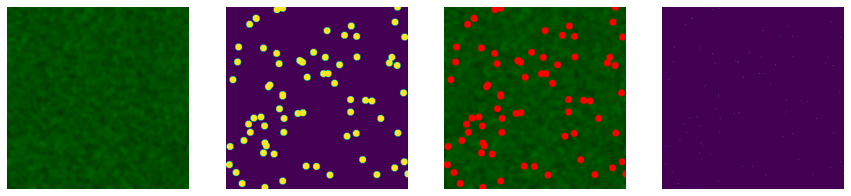

In [9]:
images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
    ax[idx].imshow(img)
    ax[idx].axis('off')

In [44]:
# Given the image, get the patches
def get_patches(img, label, verbose=False):
    img = tf.expand_dims(img, axis=0)
    label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)

    if verbose:
        print(f"Image new size: {img.shape}\nLabels new size: {label.shape}")

    num_patches = (FULL_IMAGE_HEIGHT // PATCH_HEIGHT) ** 2
    patches = tf.image.extract_patches(
        img,
        sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
        strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
        rates=[1, 1, 1, 1],
        padding="SAME",
        name="get_patches",
    )
    patches = tf.reshape(patches, [num_patches, -1])
    labels = tf.image.extract_patches(
        label,
        sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
        strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
        name="get_labels",
    )
    labels = tf.reshape(labels, [num_patches, -1])

    patch_labels = tf.math.reduce_sum(labels, axis=[1], name="calc_density")
    if verbose:
        print(f'Patches shape: {patches.shape}')
        print(f'Labels shape: {labels.shape}')
        print(f'Patch Labels shape: {patch_labels.shape}')
    
    return patches, patch_labels

In [24]:
images, labels = generate_image()
get_patches(images, labels, True)

Image new size: (1, 512, 512, 3)
Labels new size: (1, 512, 512, 1)
Patches shape: (256, 12288)
Labels shape: (256, 1024)
Patch Labels shape: (256,)


## Train a Regression Model to Predict Density

In [42]:
def create_dataset(num_full_images):
    def generate_patches():
        for i in range(num_full_images):
            img, label = generate_image()
            patches, patch_labels = get_patches(img, label)

            for patch, patch_label in zip(patches, patch_labels):
                yield patch, patch_label

    return tf.data.Dataset.from_generator(
        generate_patches,
        (tf.float32, tf.float32),
        (
            tf.TensorShape([INPUT_HEIGHT * INPUT_WIDTH * IMG_CHANNELS]),
            tf.TensorShape([]),
        ),
    )


In [45]:
trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.053850293
(12288,) 0.0 0.0744287
(12288,) 0.0 0.07555614


In [56]:
def train_and_evaluate(batch_size=BATCH_SIZE, lrate=0.001, l1=0, l2=0, num_filters=32):
    regularizer = regularizers.l1_l2(l1, l2)
    train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
    valid_dataset = create_dataset(NUM_EVAL).batch(batch_size)

    layers_ = [
        layers.Reshape(
            [INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
            input_shape=[INPUT_HEIGHT * INPUT_WIDTH * IMG_CHANNELS],
        ),
        layers.Conv2D(num_filters, (3, 3), activation="relu"),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(num_filters * 2, (3, 3), activation="relu"),
        layers.MaxPool2D((2, 2)),
        layers.Conv2D(num_filters * 2, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(
            num_filters * 2,
            kernel_regularizer=regularizer,
            kernel_initializer="he_normal",
            activation=activations.elu,
        ),
        layers.Dense(1, activation=activations.linear),
    ]

    model = Sequential(layers_, name="density_estimator")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lrate),
        loss=losses.mean_squared_error,
        metrics=["mse", "mae"],
    )
    print(model.summary())

    # Callbacks
    exponential_decay_fn = lrf.exponential_decay_with_warmup(
        lr_start=lrate / 2,
        lr_max=lrate,
        lr_min=lrate / 10,
        lr_rampup_epochs=NUM_EPOCHS // 10,
        lr_sustain_epochs=NUM_EPOCHS // 5,
        lr_exp_decay=0.25,
    )
    lr_scheduler = callbacks.LearningRateScheduler(exponential_decay_fn)

    logdir = get_logdir()
    tensorboard_cb = callbacks.TensorBoard(log_dir=logdir)

    early_stop_cb = callbacks.EarlyStopping(
        patience=NUM_EPOCHS // 10, monitor="val_mse", mode="min"
    )
    callbacks_ = [
        lr_scheduler,
        tensorboard_cb,
        early_stop_cb
    ]
    
    model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=NUM_EPOCHS,
        callbacks=callbacks_
    )
    
    return model


In [57]:
model = train_and_evaluate()

Model: "density_estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)  

In [59]:
%load_ext tensorboard
%tensorboard --logdir=../../reports/logs/chapter_11 --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 71348), started 0:30:05 ago. (Use '!kill 71348' to kill it.)

## Predictions with the model

In [60]:
def count_berries(model, img):
    num_patches = (FULL_IMAGE_HEIGHT // PATCH_HEIGHT) ** 2
    img = tf.expand_dims(img, axis=0)
    patches = tf.image.extract_patches(
        img, 
        sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
        strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
        rates=[1, 1, 1, 1],
        padding='SAME',
        name='get_patches'
    )
    patches = tf.reshape(patches, [num_patches, -1])
    densities = model.predict(patches)
    return tf.reduce_sum(densities)

31 berries generated.
8/8 [==============================] - 0s 7ms/step
47 berries generated.
8/8 [==============================] - 0s 8ms/step
58 berries generated.
8/8 [==============================] - 0s 7ms/step
64 berries generated.
8/8 [==============================] - 0s 7ms/step
46 berries generated.
8/8 [==============================] - 0s 7ms/step
70 berries generated.
8/8 [==============================] - 0s 6ms/step
55 berries generated.
8/8 [==============================] - 0s 7ms/step
43 berries generated.
8/8 [==============================] - 0s 6ms/step
30 berries generated.
8/8 [==============================] - 0s 6ms/step
53 berries generated.
8/8 [==============================] - 0s 6ms/step
61 berries generated.
8/8 [==============================] - 0s 6ms/step
43 berries generated.
8/8 [==============================] - 0s 6ms/step
29 berries generated.
8/8 [==============================] - 0s 7ms/step
60 berries generated.
8/8 [========================

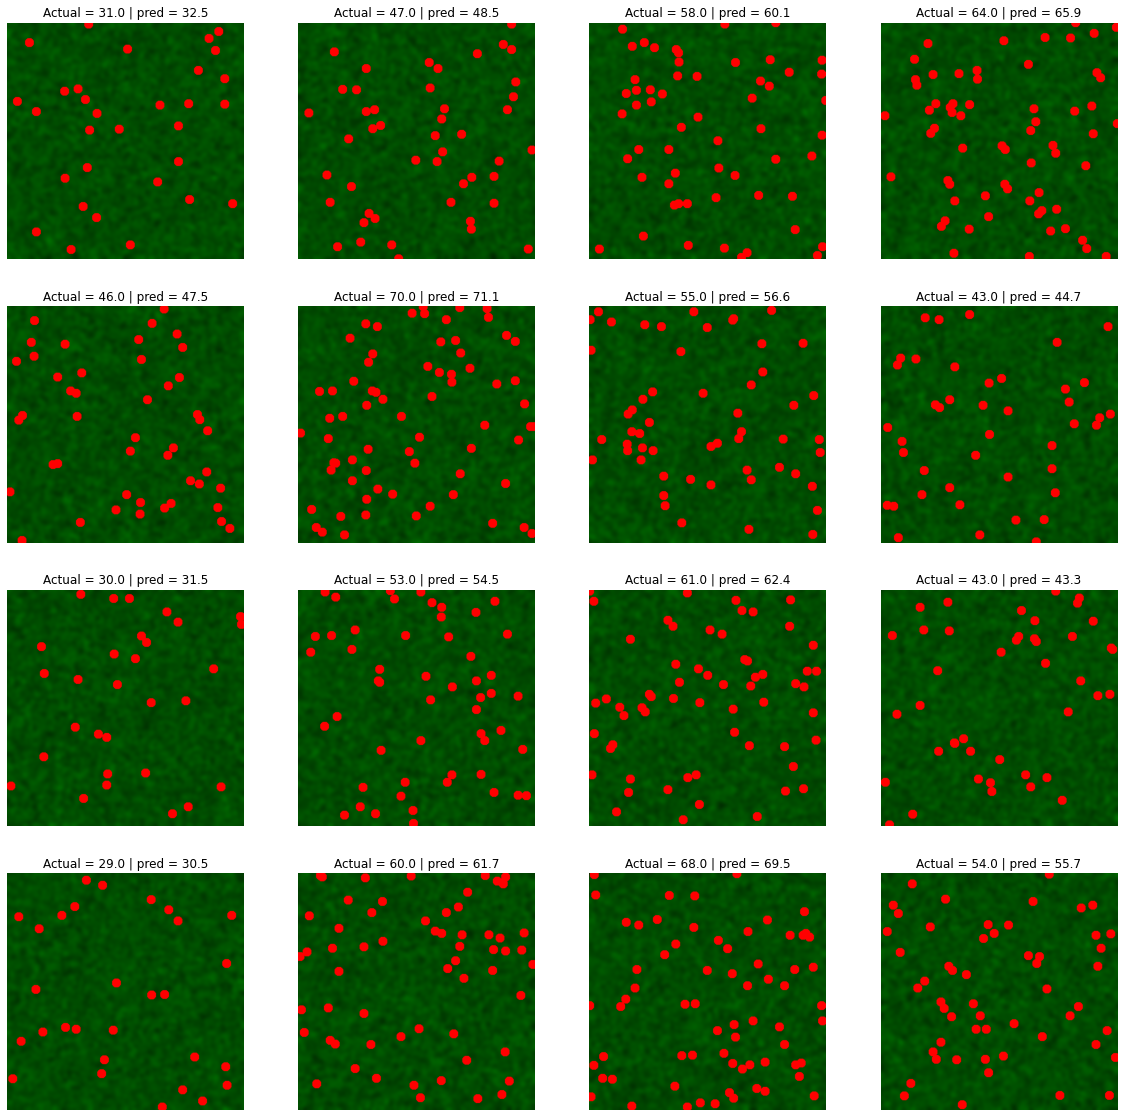

In [76]:
_, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
    background, berries, img, label = generate_image(True)
    ax[idx // 4, idx % 4].imshow(img)
    ax[idx // 4, idx % 4].set_title(
        f"Actual = {tf.reduce_sum(label).numpy():.1f} | pred = {count_berries(model, img).numpy():.1f}"
    )
    ax[idx // 4, idx % 4].axis('off')

## Actual Image

Let's predict on this image

![](test_berries.jpg)

In [84]:
!file test_berries.jpg

test_berries.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, progressive, precision 8, 400x266, components 3


In [85]:
contents = tf.io.read_file('./test_berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMAGE_HEIGHT, FULL_IMAGE_WIDTH])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 6ms/step
-718.6974
